In [2]:
from vnstock import Vnstock
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import requests

In [3]:
stock = Vnstock().stock(symbol="HPG", source="TCBS")
df = stock.quote.history(start="2020-01-01", end="2025-01-01", interval="1D")
df

,time,open,high,low,close,volume
0,2020-01-06,9.93,10.04,9.87,9.93,5371060
1,2020-01-07,9.97,10.01,9.77,9.81,4871220
2,2020-01-08,9.72,9.79,9.58,9.70,6421130
3,2020-01-09,9.77,9.99,9.77,9.93,4613440
4,2020-01-10,9.97,10.16,9.95,10.01,10006180
...,...,...,...,...,...,...
1452,2024-12-25,26.75,27.15,26.75,27.15,17153771
1453,2024-12-26,27.15,27.20,26.85,27.00,9982189
1454,2024-12-27,27.00,27.00,26.80,26.85,11397592
1455,2024-12-30,26.80,26.85,26.65,26.75,12176491


In [4]:
def get_port_price(symbols, start_date, end_date):
    result = pd.DataFrame()

    for s in symbols:
        stock = Vnstock().stock(symbol=s, source="TCBS")
        df = stock.quote.history(start=start_date, end=end_date, interval="1D")
        if result.empty:
            result["time"] = df["time"]
        result[s] = df["close"]
    result.set_index("time", inplace=True)
    return result


def get_ret_port(df):
    return np.log(df / df.shift(1))

In [5]:
port_price = get_port_price(["ACB", "HPG", "FPT"], "2020-01-01", "2025-01-01")
port_ret = get_ret_port(port_price)
port_ret

,ACB,HPG,FPT
time,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,0.000000,0.008024,-0.002052
2020-01-06,-0.021643,0.002993,-0.006595
2020-01-07,0.000000,0.029443,-0.002070
2020-01-08,-0.018182,0.006747,0.000000
...,...,...,...
2024-12-25,0.017840,0.016713,0.002656
2024-12-26,0.003922,-0.005540,-0.006653
2024-12-27,0.000000,-0.005571,-0.001336


In [6]:
np.log(port_price / port_price.shift(1))

,ACB,HPG,FPT
time,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,0.000000,0.008024,-0.002052
2020-01-06,-0.021643,0.002993,-0.006595
2020-01-07,0.000000,0.029443,-0.002070
2020-01-08,-0.018182,0.006747,0.000000
...,...,...,...
2024-12-25,0.017840,0.016713,0.002656
2024-12-26,0.003922,-0.005540,-0.006653
2024-12-27,0.000000,-0.005571,-0.001336


In [7]:
from datetime import datetime, timedelta

headers = {
    # "X-Request-Id": id,
    "pgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36 Edg/122.0.0.0",
}


def cf_analysis(stock, period):
    try:
        today = datetime.now()
        start_date = today - timedelta(days=period)
        all_data = []

        for i in range(period + 1):
            date = start_date + timedelta(days=i)
            date = date.strftime("%Y-%m-%d")
            api_url = f"https://api-finfo.vndirect.com.vn/v4/cashflow_analysis/latest?order=time&where=code:{stock}~period:30M&filter=date:{date}"
            res = requests.get(url=api_url, headers=headers)
            res.raise_for_status()
            data = res.json()
            all_data.extend(data["data"])

        df = pd.DataFrame(all_data)
        return df
    except requests.exceptions.RequestException as e:
        print("Yêu cầu không thành công:", e)
        return None

In [8]:
df = cf_analysis("HPG", 30)

,code,date,floor,time,period,totalVal,topActiveBuyVal,midActiveBuyVal,botActiveBuyVal,topActiveSellVal,...,botActiveSellVal,topActiveBuyPct,midActiveBuyPct,botActiveBuyPct,topActiveSellPct,midActiveSellPct,botActiveSellPct,netTopVal,netMidVal,netBotVal
0,HPG,2025-02-10,HOSE,14:45:00,30M,345898985.0,78978550.0,13048470.0,1299540.0,218616620.0,...,3199005.0,22.83,3.77,0.38,63.20,8.89,0.92,-139638070.0,-17708330.0,-1899465.0
1,HPG,2025-02-11,HOSE,14:45:00,30M,77719620.0,44399785.0,4641510.0,338350.0,24893185.0,...,272890.0,57.13,5.97,0.44,32.03,4.08,0.35,19506600.0,1467610.0,65460.0
2,HPG,2025-02-12,HOSE,14:45:00,30M,44062900.0,6669330.0,771845.0,88060.0,32869520.0,...,418770.0,15.14,1.75,0.20,74.60,7.37,0.95,-26200190.0,-2473530.0,-330710.0
3,HPG,2025-02-13,HOSE,14:45:00,30M,22226665.0,12588930.0,2898555.0,235735.0,4695175.0,...,106020.0,56.64,13.04,1.06,21.12,7.66,0.48,7893755.0,1196305.0,129715.0
4,HPG,2025-02-14,HOSE,14:45:00,30M,34030680.0,13322025.0,1945580.0,179865.0,16005790.0,...,242080.0,39.15,5.72,0.53,47.03,6.86,0.71,-2683765.0,-389760.0,-62215.0
5,HPG,2025-02-17,HOSE,14:45:00,30M,74016090.0,41753585.0,5615865.0,381500.0,21186525.0,...,297480.0,56.41,7.59,0.52,28.62,6.46,0.40,20567060.0,834730.0,84020.0
6,HPG,2025-02-18,HOSE,14:45:00,30M,73985935.0,43732395.0,6094425.0,418760.0,19711600.0,...,217175.0,59.11,8.24,0.57,26.64,5.15,0.29,24020795.0,2282845.0,201585.0
7,HPG,2025-02-19,HOSE,14:45:00,30M,50813175.0,27710175.0,11414670.0,783535.0,8624750.0,...,143135.0,54.53,22.46,1.54,16.97,4.21,0.28,19085425.0,9277760.0,640400.0
8,HPG,2025-02-20,HOSE,14:45:00,30M,34461990.0,11379330.0,1874430.0,148680.0,17747050.0,...,198750.0,33.02,5.44,0.43,51.50,9.04,0.58,-6367720.0,-1239320.0,-50070.0
9,HPG,2025-02-21,HOSE,14:45:00,30M,18754485.0,8176540.0,2241330.0,171955.0,6895165.0,...,108440.0,43.60,11.95,0.92,36.77,6.19,0.58,1281375.0,1080275.0,63515.0


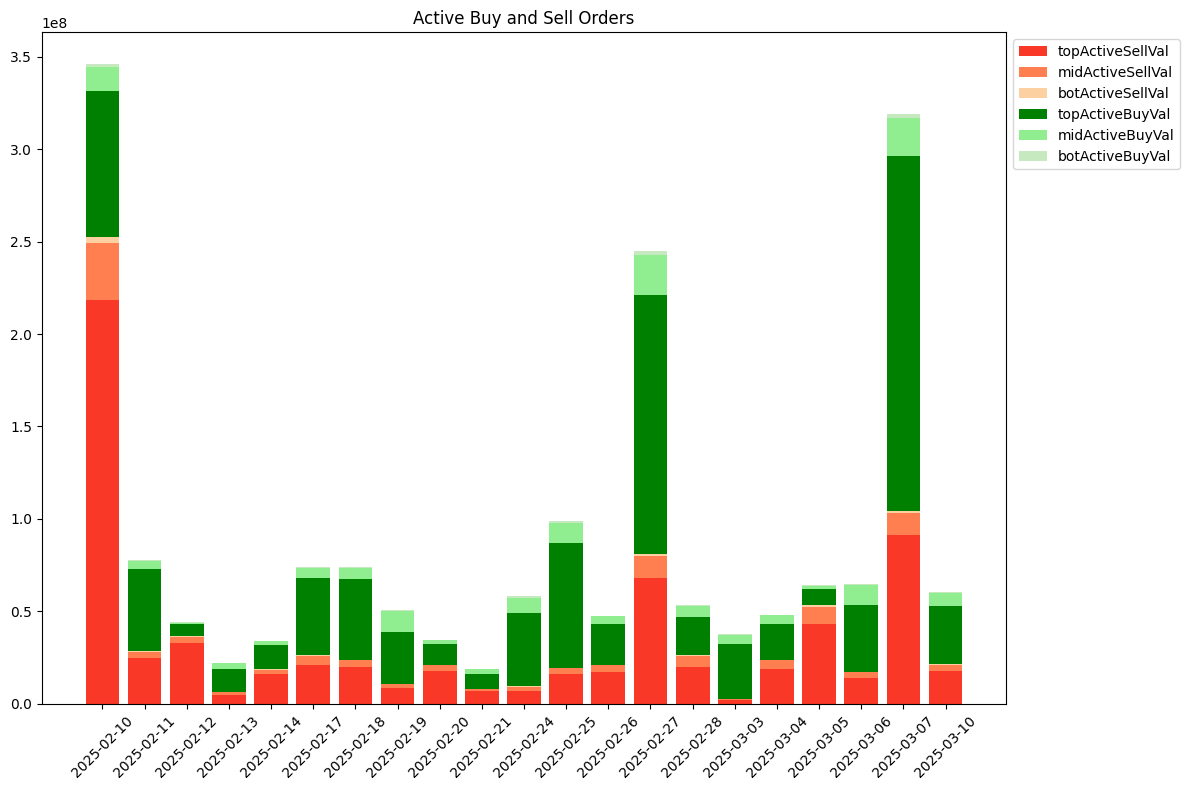

In [9]:
# Extract the relevant columns for the bar chart
buy_columns = ["topActiveBuyVal", "midActiveBuyVal", "botActiveBuyVal"]
sell_columns = ["topActiveSellVal", "midActiveSellVal", "botActiveSellVal"]
df = cf_analysis("HPG", 30)
# Create a new DataFrame for the bar chart
df_stacked = df[["date"] + buy_columns + sell_columns]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
buy_colors = ["green", "lightgreen", "#c7e9c0"]  # Green shades for buy orders
sell_colors = ["#F93827", "coral", "#fdd0a2"]  # Red shades for sell orders

# Plot sell orders
bottom_sell = np.zeros(len(df_stacked))
for col, color in zip(sell_columns, sell_colors):
    ax.bar(df_stacked["date"], df_stacked[col], bottom=bottom_sell, label=col, color=color)
    bottom_sell += df_stacked[col]

# Plot buy orders on top of sell orders
bottom_buy = bottom_sell.copy()
for col, color in zip(buy_columns, buy_colors):
    ax.bar(df_stacked["date"], df_stacked[col], bottom=bottom_buy, label=col, color=color)
    bottom_buy += df_stacked[col]

# Set labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Active Buy and Sell Orders")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()